In [11]:
#!pip install wfdb  pywavelets

In [12]:
# single_patient_biosensor_pipeline.py

# ===============================
# Step 0: Import Libraries
# ===============================
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, welch
from sklearn.ensemble import IsolationForest
from scipy.stats import entropy

In [13]:
# ===============================
# Step 1: Load Single Patient Data
# ===============================
patient_id = 'bidmc01'  # change to your file name (without extension)
record = wfdb.rdrecord(f'C:/Users/NEHA/Machine_Learning_Projects/ppg-and-respiration-dataset/bidmc-ppg-and-respiration-dataset-1.0.0/{patient_id}')  # loads .dat & .hea
signal = record.p_signal  # shape: (num_samples, num_channels)
fs = record.fs  # sampling frequency

ppg = signal[:, 0]      # PPG signal
ecg = signal[:, 1]      # ECG reference
resp = signal[:, 2]     # Respiration

print(f"Loaded {patient_id}: signal shape = {signal.shape}, fs = {fs} Hz")

Loaded bidmc01: signal shape = (60001, 5), fs = 125 Hz


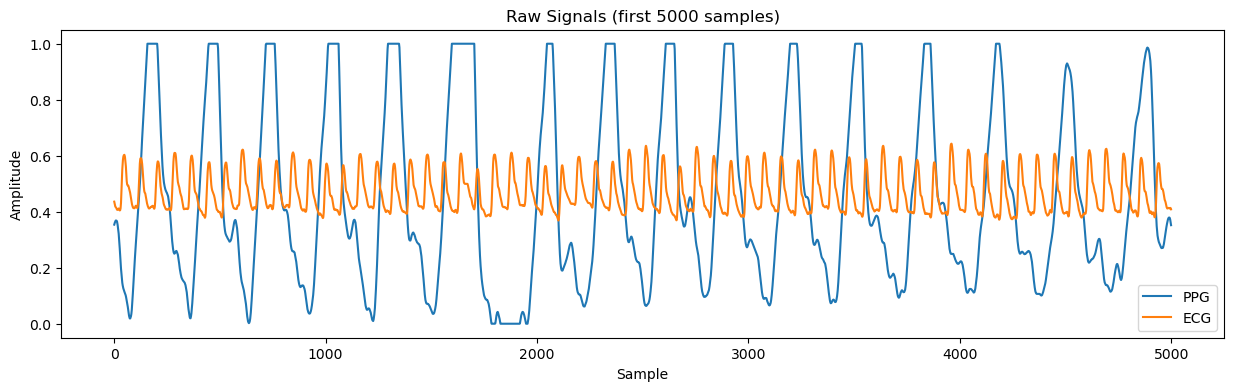

In [14]:
# ===============================
# Step 2: Exploratory Data Analysis
# ===============================
plt.figure(figsize=(15,4))
plt.plot(ppg[:5000], label='PPG')
plt.plot(ecg[:5000], label='ECG')
plt.legend()
plt.title('Raw Signals (first 5000 samples)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

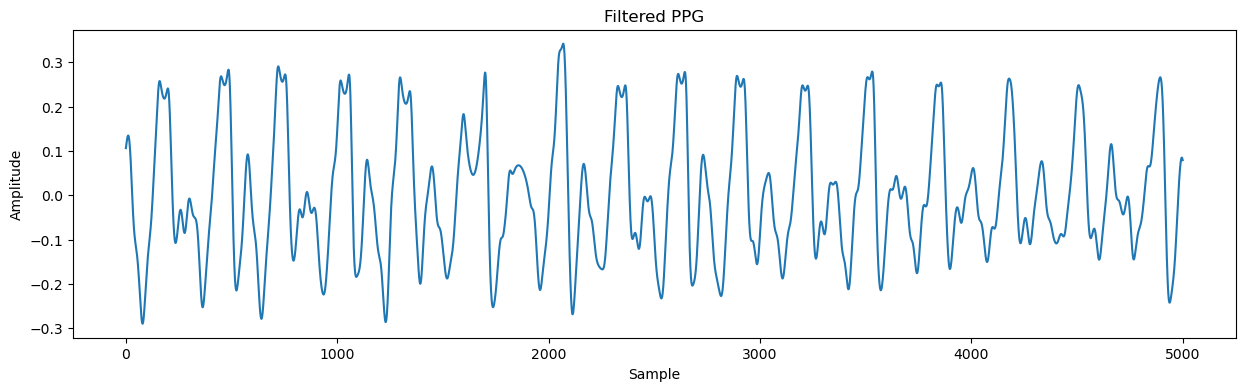

In [15]:
# ===============================
# Step 3: Preprocessing (Filtering)
# ===============================
# Bandpass filter: 0.5-5 Hz for PPG
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter(order, [lowcut/(fs/2), highcut/(fs/2)], btype='band')
    return filtfilt(b, a, data)

ppg_filtered = bandpass_filter(ppg, 0.5, 5, fs)

# Plot filtered signal
plt.figure(figsize=(15,4))
plt.plot(ppg_filtered[:5000], label='Filtered PPG')
plt.title('Filtered PPG')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# The plot generated in the previous cell shows the filtered PPG (photoplethysmogram) signal for the first 5000 samples.
# 
# - The x-axis represents the sample index (time progression).
# - The y-axis represents the amplitude of the filtered PPG signal.
# - The filtering step (bandpass 0.5-5 Hz) removes noise and baseline drift, highlighting the pulsatile waveform of the PPG.
# - You should see a cleaner, more periodic signal compared to the raw PPG, making it easier to analyze heartbeats and other physiological features.

In [16]:
# ===============================
# Step 4: Peak Detection and Time-Domain Features
# ===============================
# Find PPG peaks (min 0.5 sec between peaks)
peaks, _ = find_peaks(ppg_filtered, distance=fs*0.5)
peak_intervals = np.diff(peaks)/fs  # in seconds

print(f"Number of peaks detected: {len(peaks)}")
print(f"Mean peak interval: {np.mean(peak_intervals):.3f} s, Std: {np.std(peak_intervals):.3f} s")

Number of peaks detected: 633
Mean peak interval: 0.759 s, Std: 0.237 s


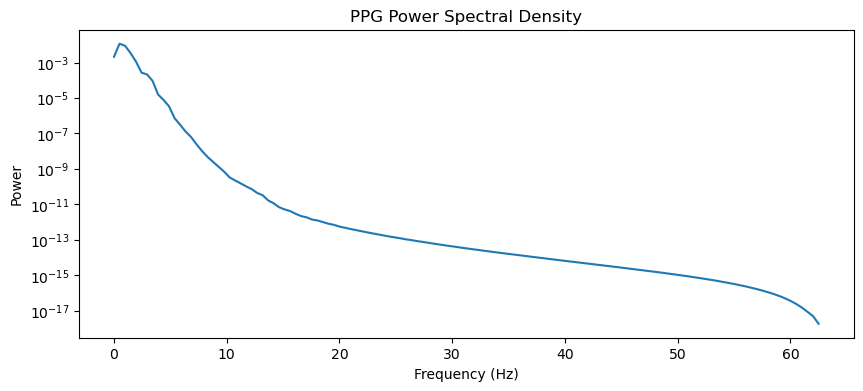

In [17]:
# ===============================
# Step 5: Frequency-Domain Features (PSD)
# ===============================
f, Pxx = welch(ppg_filtered, fs)
plt.figure(figsize=(10,4))
plt.semilogy(f, Pxx)
plt.title('PPG Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

# Explanation of the Frequency Domain Plot
The Power Spectral Density (PSD) plot displays how the power (energy) of the filtered PPG signal is distributed across different frequencies. This is computed using Welch's method, which provides a smoothed estimate of the power spectrum.

- **X-axis (Frequency in Hz)**: Represents the frequency components from 0 Hz up to half the sampling frequency (Nyquist frequency).
- **Y-axis (Power)**: Shows the power spectral density on a logarithmic scale (semilogy plot), allowing visualization of a wide range of power values.

## Key Features in PPG PSD:
- **Low-frequency components (< 0.5 Hz)**: Often related to respiration, Mayer waves (blood pressure regulation), and other slow physiological processes. These are typically attenuated by the bandpass filter (0.5-5 Hz).
- **Heart rate frequency (typically 0.8-2.5 Hz)**: The dominant peak corresponds to the heart rate. For example, a heart rate of 60 BPM (beats per minute) would appear at ~1 Hz.
- **Harmonics**: Multiples of the heart rate frequency (e.g., 2x, 3x heart rate), representing higher-order components of the pulsatile waveform.
- **Noise and artifacts**: Any remaining noise or motion artifacts may appear as broadband power across frequencies.

Since the PPG signal was filtered between 0.5-5 Hz, the plot focuses on the physiological frequency range relevant to cardiovascular monitoring. The height of the peaks indicates the strength of the signal at those frequencies, with taller peaks showing more prominent rhythms.

In [18]:
# Spectral entropy as SQI
P_norm = Pxx / np.sum(Pxx)
spectral_entropy = -np.sum(P_norm*np.log2(P_norm))
print(f"Spectral Entropy (SQI): {spectral_entropy:.3f}")

Spectral Entropy (SQI): 2.055


In [ ]:
Spectral entropy is a measure of the complexity or randomness of a signal in the frequency domain. It quantifies how the power of a signal is distributed across different frequency components, using the concept of Shannon entropy.

- **Low spectral entropy**: Indicates that most of the signal’s power is concentrated in a few frequency bands (the signal is more regular or periodic).
- **High spectral entropy**: Indicates that the power is spread out over many frequencies (the signal is more random or noisy).

It is commonly used as a Signal Quality Index (SQI) in biomedical signal processing to assess the regularity or disorder in physiological signals like PPG or EEG.

In [19]:
# ===============================
# Step 6: Abnormality Detection
# ===============================
# Features for anomaly detection: peak intervals + spectral entropy
features = np.column_stack([peak_intervals, np.full(len(peak_intervals), spectral_entropy)])

# Isolation Forest for anomaly detection
clf = IsolationForest(contamination=0.05, random_state=42)
labels = clf.fit_predict(features)  # -1 = anomaly, 1 = normal

print(f"Number of anomalies detected: {np.sum(labels==-1)}")

Number of anomalies detected: 32


In [ ]:
explain how anomalies are detected in the above code?


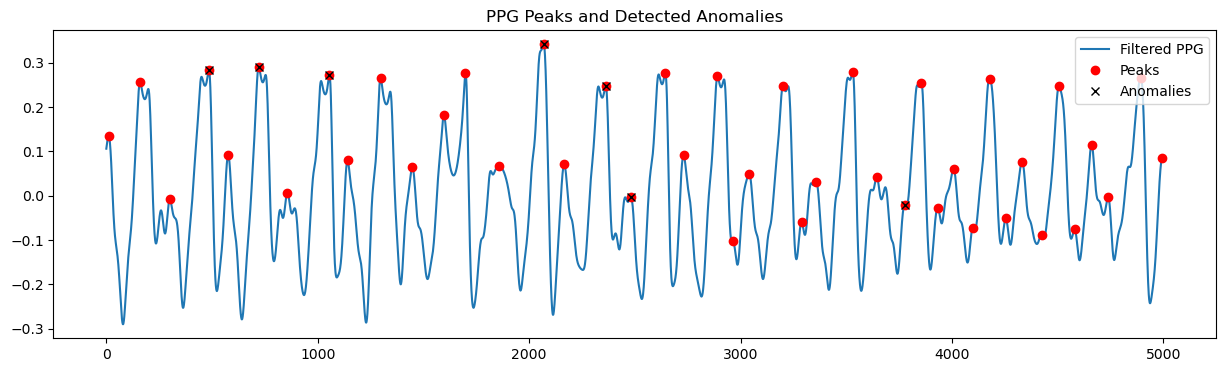

In [20]:
# Highlight anomalies
anomaly_peaks = peaks[1:][labels==-1]
plt.figure(figsize=(15,4))
plt.plot(ppg_filtered[:5000], label='Filtered PPG')
plt.plot(peaks[peaks<5000], ppg_filtered[peaks[peaks<5000]], 'ro', label='Peaks')
plt.plot(anomaly_peaks[anomaly_peaks<5000], ppg_filtered[anomaly_peaks[anomaly_peaks<5000]], 'kx', label='Anomalies')
plt.title('PPG Peaks and Detected Anomalies')
plt.legend()
plt.show()

In [ ]:
# The detected peaks are labeled as anomalies because their associated features (peak interval and spectral entropy)
# are considered unusual by the Isolation Forest model. The model is trained on the majority of "normal" feature patterns,
# and it assigns an anomaly label (-1) to peaks whose feature values (e.g., unusually short/long intervals or abnormal entropy)
# deviate significantly from the learned distribution. This helps identify irregular heartbeats or signal artifacts in the PPG data.

In [21]:
# ===============================
# Step 7: Summary / Reporting
# ===============================
print("Single-Patient Summary:")
print(f"- Total Peaks: {len(peaks)}")
print(f"- Mean Peak Interval: {np.mean(peak_intervals):.3f} s")
print(f"- Std Peak Interval: {np.std(peak_intervals):.3f} s")
print(f"- Spectral Entropy (SQI): {spectral_entropy:.3f}")
print(f"- Anomalies Detected: {np.sum(labels==-1)}")

Single-Patient Summary:
- Total Peaks: 633
- Mean Peak Interval: 0.759 s
- Std Peak Interval: 0.237 s
- Spectral Entropy (SQI): 2.055
- Anomalies Detected: 32
